In [1]:
import sys
sys.path.append("..")
from allthethings import PyNetwork, PyPipe_ps
from allthethings import PyBC_opt_dh
import numpy as np
import matplotlib.pyplot as plt
%pylab inline
from scipy import optimize
from writeit import rewritePipes
import pickle

Populating the interactive namespace from numpy and matplotlib


In [2]:
def idx_t(i,j,n,N):
    return (2*(N+2)*n+(N+2)*i+j)

In [3]:
fi = "../indata/Alameda62.0.0.inp" 
fc = "../indata/Alameda62.0.config"
n0 = PyNetwork(fi,fc,1)
print n0.Ls
print n0.Ns
print n0.Ds

[ 116.43  214.15   57.79   62.33   70.59   37.98   73.46   77.42   75.9
  101.19   77.72   82.91   41.45   39.93   75.22  108.51  104.24   58.83
  103.33  101.5   123.14   40.84   58.83   19.81   20.42  256.03  130.76
   10.36   60.96   91.44   13.11   60.96   91.44]
[24 43 12 13 15  8 15 16 16 21 16 17  9  8 16 22 21 12 21 21 25  9 12  4  5
 52 27  3 13 19  3 13 19]
[ 0.102  0.102  0.102  0.102  0.102  0.102  0.102  0.102  0.102  0.102
  0.102  0.102  0.102  0.102  0.102  0.102  0.051  0.102  0.051  0.051
  0.102  0.051  0.051  0.051  0.051  0.051  0.051  0.102  0.102  0.051
  0.102  0.102  0.051]


In [4]:
Ls = n0.Ls
T = 20
Mi = 40   #number of time steps in between writes
Nt =60
Ttot = Nt*T
Np = n0.Nedges
a = 100
Ns = [int(l) for l in Ls]
Ds = n0.Ds
dx = [Ls[i]/Ns[i] for i in range(Np)]
M = int(T*a/(max(dx)*.8))*4
M = (M+Mi-M%Mi)  #round it up to be an even multiple of Mi
jt = n0.nodeTypes
Nn = len(jt)
bt = [2]*Nn
bv = [0]*Nn
bt[0] = 0
r = [0]*Nn
r[0] = 0
r[17] =1
r[19]=1
r[20]=1

#r[16] = -1
bt[0] =1
h0s = [0]*Np
h0s = [.1*d*d/4*np.pi for d in Ds]
q0s = [1]*Np
Mrs =[0.007]*Np
#Mrs =[0.0]*Np
print T
print M
Nstar =1 #measuring point for each pipe
Hs =np.ndarray((Np,M/Mi*Nt))
print (T/float(M))/min(dx)*a
print min(Ns)
print T*Nt/60.
print r
elevs = [127.10, 126.19, 98.76, 91.44, 83.82, 78.029, 70.74, 61.26, 53.95, 57.9, 58.52, 60.05, 60.66, 62.79, 63.70, 73.15, 76.81, 76.2, 86.26, 84.43, 88.09, 96.32, 96.012, 99.67, 101.80, 103.63, 101.80, 101.19, 101.50, 103.95, 117.96, 129.84, 87.48, 97.23]

20
9600
0.208308922132
10
20.0
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [5]:
Hs =np.zeros((M/Mi*Nt,sum(Ns)))#[H0(t0), H1(t0),,,H7(t0);H0(t1)...; ]
Us =np.zeros((M/Mi*Nt,sum(Ns)))#
Hs2 = np.zeros((Np,M/Mi*Nt))
fn = "../indata/Alameda_m4"
oldinp = "../indata/Alameda62.0.0.inp"
(fi, fc) = rewritePipes(fn,oldinp, Ns, Ls, Mrs, Ds, jt, bt, bv, r, h0s, q0s, T, M, a, elevs)
n1 = PyNetwork(fi,fc,1)
dt = n1.T/float(n1.M)
Q00 = 0.0087
j = 0
ICdata = pickle.load(open('summary_results_saved_at2015_11_15_16_40_13.pkl','rb'))
Af = ICdata['Af']
Qf = ICdata['Qf']

for i in range(0,Np):
    Ai = ((Ds[i]**2)/4.)*np.pi
    #initial condition empty
    A0 = .01*Ai*ones(n1.Ns[i])
    p0 = PyPipe_ps(n1.Ns[i],n1.Ds[i], n1.Ls[i],M,a)
    Q0 = 0*np.ones(n1.Ns[i])
    #print "Af = %f, A0= %f, H0/D = %f"%(Ai, A0[0], p0.HofA(A0[0],False)/Ds[i])
    #subsequent runs use old data
    A0 = Af[i]
    Q0 = Qf[i]
    n1.setIC(i,A0,Q0)
N = n1.Ns[j]
p0 = PyPipe_ps(N,n1.Ds[0], n1.Ls[0],M,a)
A00 = p0.AofH(20,False)
n1.setIC(0,A00*np.ones(n1.Ns[0]), Q00*np.ones(n1.Ns[0]))
#n1.setIC(1,A00*np.ones(n1.Ns[1]), Q00*np.ones(n1.Ns[1]))
Qb = Q00*np.ones(M+1)
#Qb = 0.00796866547379*np.ones(M+1)  #A = 100
#Qo = 0.04*np.ones(M+1)
#Ab = A00*np.ones(M+1)
aa=arange(0,len(n1.nodeTypes))
for j in range(len(aa[n1.nodeTypes==1])):
    n1.setbVal(j,n1.Ds[0]*.1*np.ones(M+1))
n1.setbVal(0,Qb)
#for i in range(n1.Nedges):
#    print "%d    %d" %(i,n1.Ns[i])
#p0 = PyPipe_ps(n1.Ns[11],n1.Ds[11], n1.Ls[11],M, a)
print shape(Hs)
print Ttot/60
print dt*Mi

(14400, 2641)
20
0.0833333333333


In [6]:
aa=arange(0,len(n1.nodeTypes))
print aa[n1.nodeTypes==1]

[ 0 17 19 20 22 23 25 31]


In [7]:
#c= p0.Cgrav(1e-6,False) 
print a
print n1.Ls[16]/n1.Ns[16]
print n1.Ds[16]
print dt
print np.pi*(.05**2)/4.
n1.showCurrentData()
print n1.T

100
1.0
0.05
0.00208333333333
0.00196349540849
At time t = 0.000000
Data from pipe 0
A           Q
0.008007    0.008700
0.008007    0.008700
0.008007    0.008700
0.008007    0.008700
0.008007    0.008700
0.008007    0.008700
0.008007    0.008700
0.008007    0.008700
0.008007    0.008700
0.008007    0.008700
0.008007    0.008700
0.008007    0.008700
0.008007    0.008700
0.008007    0.008700
0.008007    0.008700
0.008007    0.008700
0.008007    0.008700
0.008007    0.008700
0.008007    0.008700
0.008007    0.008700
0.008007    0.008700
0.008007    0.008700
0.008007    0.008700
0.008007    0.008700
0.008007    0.008700
0.008007    0.008700
0.008007    0.008700
0.008007    0.008700
0.008007    0.008700
0.008007    0.008700
0.008007    0.008700
0.008007    0.008700
0.008007    0.008700
0.008007    0.008700
0.008007    0.008700
0.008007    0.008700
0.008007    0.008700
0.008007    0.008700
0.008007    0.008700
0.008007    0.008700
0.008007    0.008700
0.008007    0.008700
0.008007    0.00870

In [8]:
%%time 
Vs = [n1.getTotalVolume()]
for m in range(Nt):
    n1.runForwardProblem(dt)
    print 'T =%f'%(T*(m+1))
    Ntot = 0
    for j in range(Np):
        N = n1.Ns[j]
        p0 = PyPipe_ps(N,n1.Ds[j], n1.Ls[j],M,a)
        qh = n1.qhist(j)
        for n in range(1,M+1,Mi):
            Htemp=[p0.pbar(qh[idx_t(0,k,n,N)],False) for k in range(1,N+1)]
            Utemp = [qh[idx_t(1,k,n,N)]/qh[idx_t(0,k,n,N)] for k in range(1,N+1)]
            Hs[(n-1)/Mi+m*(M/Mi),Ntot:Ntot+N] = Htemp
            Us[(n-1)/Mi+m*(M/Mi),Ntot:Ntot+N] = Utemp
        Ntot+=N
        #Htemp2 = [p0.pbar(qh[idx_t(0,Nstar,n,n1.Ns[j])],False) for n in range(1,M+1,Mi)]
        #Hs2[j,m*(M/Mi):(M/Mi)*(m+1)] = Htemp2
    Vs.append(n1.getTotalVolume()) 
    print m
    print Vs
    n1.reset()

T =20.000000
0
[11.729354029175393, 11.719521667343317]
T =40.000000
1
[11.729354029175393, 11.719521667343317, 11.718034628755994]
T =60.000000
2
[11.729354029175393, 11.719521667343317, 11.718034628755994, 11.737948197428587]
T =80.000000
3
[11.729354029175393, 11.719521667343317, 11.718034628755994, 11.737948197428587, 11.752671980986564]
T =100.000000
4
[11.729354029175393, 11.719521667343317, 11.718034628755994, 11.737948197428587, 11.752671980986564, 11.759092185667125]
T =120.000000
5
[11.729354029175393, 11.719521667343317, 11.718034628755994, 11.737948197428587, 11.752671980986564, 11.759092185667125, 11.7594530785634]
T =140.000000
6
[11.729354029175393, 11.719521667343317, 11.718034628755994, 11.737948197428587, 11.752671980986564, 11.759092185667125, 11.7594530785634, 11.760049960637419]
T =160.000000
7
[11.729354029175393, 11.719521667343317, 11.718034628755994, 11.737948197428587, 11.752671980986564, 11.759092185667125, 11.7594530785634, 11.760049960637419, 11.75889212422

In [9]:
blargh = np.zeros((M/Mi*Nt,sum(n1.Ns)))
print len(find(blargh<1))           
for m in range(Nt):
    Ntot=0
    for j in range(Np):
        N = n1.Ns[j]
        for n in range(1,M+1,Mi):
            blargh[(n-1)/Mi+m*(M/Mi),Ntot:Ntot+N]=np.ones(N)
        Ntot+=N


38030400


In [10]:
print m*M/Mi
print (M/Mi)*(m+1)
print Nstar

14160
14400
1


a = 100.0 m/s
inflow volume = 3099.14 gallons
system volume = 4090.593358
2763.49997683
95.077875


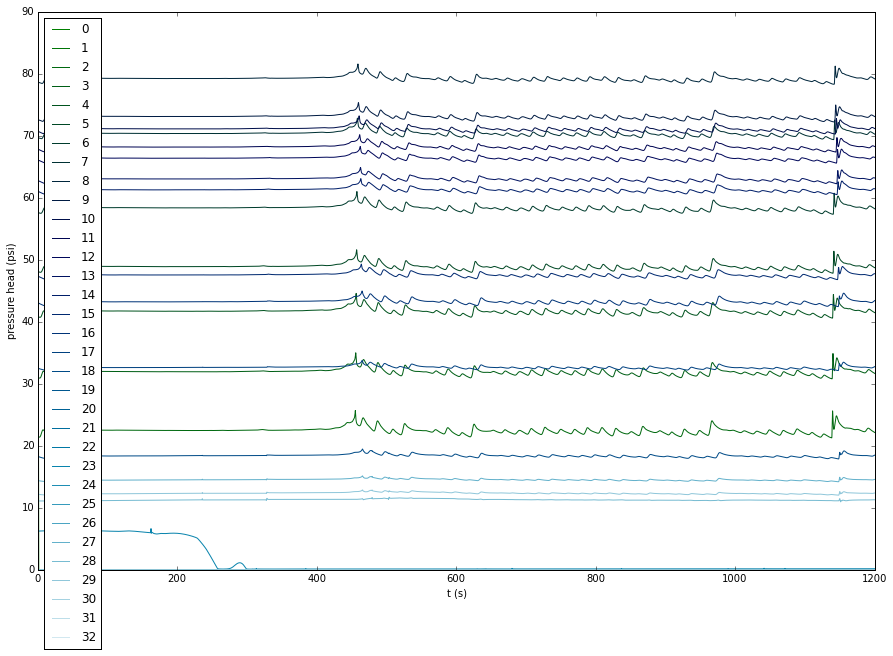

In [12]:
m2psi = 1.42

from matplotlib import cm
import matplotlib.colors as colors  
cNorm  = colors.Normalize(vmin=0, vmax=Np+1)
fig,ax = plt.subplots(figsize=(15,10))
scalarMap = cm.ScalarMappable(norm=cNorm, cmap=cm.get_cmap('ocean'))
t = linspace(0,Ttot,M/Mi*Nt)
Ntot = 0
interesting = (16,18,19,20,29,32)
interesting = (28,30,31,21)
interesting = (19,20,21,24,25,26,30,31)
interesting = arange(0,Np)
for k in interesting:
    plot(t,m2psi*Hs[:,sum(Ns[0:k])],label="%d"%k, color = scalarMap.to_rgba(k))
    #plot(t,m2psi*Hs2[k,:],'g',label="%d"%k)# color = scalarMap.to_rgba(k))
xlabel('t (s)')
ylabel('pressure head (psi)')
#xlim(1200,1250)
#ylim(0,200)
legend(loc = 'upper left')
m32gal=264.172052
print "a = %.1f m/s" %a
Vsys = 0
for k in range(Np):
    Vsys +=Ls[k]*(Ds[k]**2)/4.*np.pi
print "inflow volume = %.2f gallons"%((Vs[-1])*m32gal)
print "system volume = %f"% (Vsys*m32gal)
k = 17
print norm(Hs2[k,:]-Hs[:,sum(Ns[0:k])])
print n1.solve_time*Nt/60

116
[  0   2   4   6   8  10  12  14  16  18  20  22  24  26  28  30  32  34
  36  38  40  42  44  46  48  50  52  54  56  58  60  62  64  66  68  70
  72  74  76  78  80  82  84  86  88  90  92  94  96  98 100 102 104 106
 108 110 112 114]
0.00208333333333
100
103.0
101.0
123.0


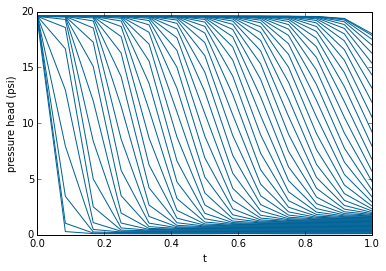

In [22]:
interesting = arange(0,Ns[0],2)
t = linspace(0,T*Nt,M/Mi*Nt)
print Ns[0]
cNorm  = colors.Normalize(vmin=0, vmax=len(interesting)+5)
scalarMap2 = cm.ScalarMappable(norm=cNorm, cmap=cm.get_cmap('ocean'))
print interesting
for i in interesting:
    plot(t,Hs[:,i], color = scalarMap.to_rgba(20))
print dt
print a
#xticks(linspace(280,290,11))
grid(False)
xlabel('t')
xlim(0,1)
ylim(0,20)
ylabel('pressure head (psi)')
print n1.Ls[18]
print n1.Ls[19]
print n1.Ls[20]
legend(loc = 'upper left')


In [20]:
# combination that works to 140 s: Q0 = 0.05Af, r = -1 everywhere.

In [21]:
print n1.solve_time*Nt/60

222.174171333


In [27]:

Note = "initial condition is (0.01*Afull, 0.0087) everywhere except pipe 0, which has (HofA(20, 0.0087)\
    boundary condition is Q =.0087 at node 0.\
    all other junctions have r=0, orifice flow with bval=0.1*D, except nodes 20,22,23,25 which have r=1\
    base inp file is %s"%oldinp
rtime = "CPU times:  user 4h 45min 12s, sys: 1min 5s, total: 4h 46min 17s\
Wall time: 4h 46min 10s"

In [28]:
Af = []
Qf = []
for k in range(Np):
    q = n1.q(k)
    Af.append(np.array(q[0:Ns[k]]))
    Qf.append(np.array(q[ Ns[k]:]))

In [ ]:
import time
solve_t = (n1.solve_time)*Nt
t = time.localtime()
s = "%d_%d_%d_%d_%d_%d"%(tuple([t[i] for i in range(6)]))
f1=  open('results_%d_s_saved_at%s.pkl'%(int(Ttot),s),'wb')
data = {'Hs':Hs, 'Us':Us, 'elevs':elevs,'T':T,'Tot':Ttot,
        'conns': n1.conn, 
        'Ds': n1.Ds, 
        'Ls':n1.Ls,
        'Ns':n1.Ns,
        'Mrs':Mrs,
        'M':M, 
        'Nt': Nt,
        'Ttot':Ttot,
        'r':r, 
        'bt':bt,
        'bv':bv,
        'Mi': Mi, 'a':a, 'solve_t':solve_t, 'Q00': Q00,
        'notes':Note,
         "reported time":rtime, 
       'Af':Af,
       'Qf': Qf,
       'Vs':Vs}
pickle.dump(data,f1)
f1.close()

In [36]:
print len(Af)
print len(Qf)
print T*Nt
print s

33
33
2800
2015_11_15_16_40_13


In [37]:
print f1

<closed file 'results_2800_s_saved_at2015_11_15_16_40_13.pkl', mode 'wb' at 0x139dbbb70>


In [13]:
for k in range(Np):
    print "%d     %f"%(k,m2psi*max(Hs[-1,sum(Ns[0:k]):sum(Ns[0:k+1])]))

0     1.194038
1     140.119170
2     31.575428
3     41.409500
4     48.608552
5     58.081423
6     70.189604
7     79.229094
8     79.247929
9     73.164505
10     71.227245
11     68.331997
12     66.581315
13     63.261340
14     61.522803
15     47.820783
16     74.590358
17     32.832758
18     32.128000
19     0.000062
20     0.002171
21     0.004350
22     3.036326
23     6.271818
24     0.000476
25     0.001083
26     0.000960
27     14.644857
28     48.671076
29     21.594927
30     0.000104
31     0.000703
32     0.002561


In [39]:
f2 = open('summary_results_saved_at%s.pkl'%s,'wb')

In [40]:
data = {'elevs':elevs,'T':T,'Tot':Ttot,
        'conns': n1.conn, 
        'Ds': n1.Ds, 
        'Ls':n1.Ls,
        'Ns':n1.Ns,
        'Mrs':Mrs,
        'M':M, 
        'Nt': Nt,
        'Ttot':Ttot,
        'r':r, 
        'bt':bt,
        'bv':bv,
        'Mi': Mi, 'a':a, 'solve_t':solve_t, 'Q00': Q00,
        'notes':Note,
         "reported time":rtime, 
       'Af':Af,
       'Qf': Qf,
     'Vs':Vs}
pickle.dump(data,f2)
f2.close()

In [41]:
print shape(Hs)

(33600, 2641)


In [42]:
for k in 

SyntaxError: invalid syntax (<ipython-input-42-6470dac8ddb1>, line 1)

In [43]:
print f2


<closed file 'summary_results_saved_at2015_11_15_16_40_13.pkl', mode 'wb' at 0x139dbbc90>


In [55]:
print Qf

[array([  8.39540944e-03,   8.05859830e-03,   7.72178267e-03,
         7.38496256e-03,   7.04813796e-03,   6.71130888e-03,
         6.37447533e-03,   6.03763730e-03,   5.70079480e-03,
         5.36394784e-03,   5.02709643e-03,   4.69024056e-03,
         4.35338024e-03,   4.01651549e-03,   3.67964630e-03,
         3.34277268e-03,   3.00589465e-03,   2.66901220e-03,
         2.33212535e-03,   1.99523411e-03,   1.65833848e-03,
         1.32143848e-03,   9.84534113e-04,   6.47625389e-04,
         3.10712321e-04,  -2.62050686e-05,  -3.63124700e-04,
        -7.00045084e-04,  -1.03696623e-03,  -1.37388814e-03,
        -1.71081082e-03,  -2.04773429e-03,  -2.38465854e-03,
        -2.72158360e-03,  -3.05850946e-03,  -3.39543613e-03,
        -3.73236363e-03,  -4.06929197e-03,  -4.40622115e-03,
        -4.74315119e-03,  -5.08008209e-03,  -5.41701388e-03,
        -5.75394655e-03,  -6.09088013e-03,  -6.42781463e-03,
        -6.76475005e-03,  -7.10168641e-03,  -7.43862374e-03,
        -7.77556203e-03

In [56]:
print Af

[array([ 0.04168066,  0.04168099,  0.04168131,  0.04168163,  0.04168196,
        0.04168229,  0.04168261,  0.04168294,  0.04168327,  0.04168359,
        0.04168392,  0.04168425,  0.04168458,  0.04168491,  0.04168524,
        0.04168556,  0.04168589,  0.04168622,  0.04168655,  0.04168688,
        0.04168721,  0.04168754,  0.04168787,  0.0416882 ,  0.04168853,
        0.04168886,  0.04168919,  0.04168951,  0.04168984,  0.04169017,
        0.0416905 ,  0.04169083,  0.04169115,  0.04169148,  0.04169181,
        0.04169214,  0.04169247,  0.0416928 ,  0.04169312,  0.04169345,
        0.04169378,  0.04169411,  0.04169444,  0.04169477,  0.0416951 ,
        0.04169543,  0.04169577,  0.0416961 ,  0.04169643,  0.04169676,
        0.0416971 ,  0.04169743,  0.04169777,  0.0416981 ,  0.04169844,
        0.04169878,  0.04169912,  0.04169946,  0.0416998 ,  0.04170014,
        0.04170048,  0.04170082,  0.04170117,  0.04170151,  0.04170186,
        0.04170221,  0.04170256,  0.04170291,  0.04170326,  0.0

In [57]:
print Vs[-1]*m32gal

30066.5637981
